# TEST DATA
---
---

# Table of Contents
---

# Sources
---

In [1]:
# https://stackoverflow.com/questions/25120621/python-get-date-in-future-x-days-and-hours-left-to-date
# https://stackoverflow.com/questions/61416251/in-dataframe-add-time-offset-column-to-another-datetime-column
# https://www.geeksforgeeks.org/python-pandas-timedelta-seconds/

# Imports
---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta, datetime
import time

# GPX file
import gpxpy
import gpxpy.gpx

# GPX file
from bs4 import BeautifulSoup
import lxml

# bearing
from geographiclib.geodesic import Geodesic

# distance
import haversine as hs

# API
import requests
from pandas import json_normalize

%matplotlib inline
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter("ignore")

In [3]:
API_key = 'd43015e86fe9a04995afe46ef9ad42c4'

In [4]:
# Open .gpx file and parse xml
with open('../data/marin_century_classic_2022.gpx', 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

In [5]:
# check out .gpx file as xml
gpx.to_xml()[:2000]

'<?xml version="1.0" encoding="UTF-8"?>\n<gpx xmlns="http://www.topografix.com/GPX/1/1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd" version="1.1" creator="StravaGPX">\n  <metadata>\n    <name>Marin Century Classic 2022</name>\n    <author>\n      <name>Adriana Machado</name>\n      <link href="https://www.strava.com/athletes/7321904">\n      </link>\n    </author>\n    <copyright author="OpenStreetMap contributors">\n      <year>2020</year>\n      <license>https://www.openstreetmap.org/copyright</license>\n    </copyright>\n    <link href="https://www.strava.com/routes/2951301224719649896">\n    </link>\n  </metadata>\n  <trk>\n    <name>Marin Century Classic 2022</name>\n    <link href="https://www.strava.com/routes/2951301224719649896">\n    </link>\n    <type>Ride</type>\n    <trkseg>\n      <trkpt lat="38.11272" lon="-122.65319000000001">\n        <ele>63.04</ele>\n      </trk

# GPX Import to Dataframe
---

In [6]:
# check length of tracks
print(f'Tracks: {len(gpx.tracks)}')
# check number of data points
print(f'No. of Track Points: {gpx.get_track_points_no()}')

# extract timestamp, lat, lon, and elevation from gpx file
route_info = []

for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                'latitude': point.latitude,
                'longitude': point.longitude,
                'elevation': point.elevation,
            })

# create dataframe
test_df = pd.DataFrame(route_info)
test_df.head()

Tracks: 1
No. of Track Points: 2849


,latitude,longitude,elevation
0,38.11272,-122.65319,63.04
1,38.11343,-122.65308,63.40
2,38.11370,-122.65309,63.68
3,38.11425,-122.65358,64.76
4,38.11461,-122.65354,65.55


In [7]:
test_df.isnull().sum()

latitude     0
longitude    0
elevation    0
dtype: int64

## Create Bearing Column

In [8]:
def get_bearing(lat1, lat2, long1, long2):
    brng = Geodesic.WGS84.Inverse(lat1, long1, lat2, long2)['azi1']
    return brng

In [9]:
get_bearing(38.773795, 38.773860, -121.363652, -121.363689)

-24.017929532262528

In [10]:
test_df['bearing'] = 0
for i in range(1, len(test_df)):
    lat1 = test_df.latitude.iloc[i-1]
    lat2 = test_df.latitude.iloc[i]
    long1 = test_df.longitude.iloc[i-1]
    long2 = test_df.longitude.iloc[i]
    bearing = get_bearing(lat1, lat2, long1, long2)
    # https://stats.stackexchange.com/questions/283572/using-iloc-to-set-values
    test_df.bearing.iloc[[i]] = bearing

In [11]:
test_df.head()

,latitude,longitude,elevation,bearing
0,38.11272,-122.65319,63.04,0.000000
1,38.11343,-122.65308,63.40,6.978612
2,38.11370,-122.65309,63.68,-1.676102
3,38.11425,-122.65358,64.76,-35.140713
4,38.11461,-122.65354,65.55,5.016818


# Create Elevation Columns
---

In [12]:
# ELEVATION CHANGE - METERS
test_df['ele_diff_m'] = 0
for i in range(1, len(test_df)-1):
    e1 = test_df.iloc[i]['elevation']
    e2 = test_df.iloc[i-1]['elevation']
    test_df.at[i, 'ele_diff_m'] = (e1 - e2)
test_df['total_ele_change_m'] = round(test_df['ele_diff_m'].cumsum(skipna = True), 4)
test_df.head()

,latitude,longitude,elevation,bearing,ele_diff_m,total_ele_change_m
0,38.11272,-122.65319,63.04,0.000000,0.00,0.00
1,38.11343,-122.65308,63.40,6.978612,0.36,0.36
2,38.11370,-122.65309,63.68,-1.676102,0.28,0.64
3,38.11425,-122.65358,64.76,-35.140713,1.08,1.72
4,38.11461,-122.65354,65.55,5.016818,0.79,2.51


# Create Distance Columns
---

In [13]:
# DISTANCE - KILOMETERS
test_df['lat_lon'] = [(lat, lon) for lat, lon in zip(test_df['latitude'], test_df['longitude'])]
test_df['dist_diff_km'] = 0
for i in range(1, len(test_df)-1):
    loc1 = test_df.iloc[i]['lat_lon']
    loc2 = test_df.iloc[i-1]['lat_lon']
    test_df.at[i, 'dist_diff_km'] = round(hs.haversine(loc1, loc2), 4) # kilometers
test_df['total_dist_km'] = test_df['dist_diff_km'].cumsum(skipna = True)
test_df.head()

,latitude,longitude,elevation,bearing,ele_diff_m,total_ele_change_m,lat_lon,dist_diff_km,total_dist_km
0,38.11272,-122.65319,63.04,0.000000,0.00,0.00,"(38.11272, -122.65319000000001)",0.0000,0.0000
1,38.11343,-122.65308,63.40,6.978612,0.36,0.36,"(38.11343, -122.65308000000002)",0.0795,0.0795
2,38.11370,-122.65309,63.68,-1.676102,0.28,0.64,"(38.1137, -122.65309)",0.0300,0.1095
3,38.11425,-122.65358,64.76,-35.140713,1.08,1.72,"(38.114250000000006, -122.65358)",0.0747,0.1842
4,38.11461,-122.65354,65.55,5.016818,0.79,2.51,"(38.114610000000006, -122.65354)",0.0402,0.2244


In [14]:
test_df.tail()

,latitude,longitude,elevation,bearing,ele_diff_m,total_ele_change_m,lat_lon,dist_diff_km,total_dist_km
2844,38.11461,-122.65354,65.49,-152.817726,-0.18,2.45,"(38.114610000000006, -122.65354)",0.0250,161.3451
2845,38.11425,-122.65358,64.76,-174.983157,-0.73,1.72,"(38.114250000000006, -122.65358)",0.0402,161.3853
2846,38.11370,-122.65309,63.68,144.858985,-1.08,0.64,"(38.1137, -122.65309)",0.0747,161.4600
2847,38.11343,-122.65308,63.40,178.323892,-0.28,0.36,"(38.11343, -122.65308000000002)",0.0300,161.4900
2848,38.11299,-122.65314,63.22,-173.850794,0.00,0.36,"(38.11299, -122.65314000000001)",0.0000,161.4900


# Time and Elapsed Time
---
*Using average and high means from training sets' time_diff_s for respective test datasets. Mean is reasonable and accounts for potential breaks that cause the outlier time differences between trackpoints when the Garmin sensor was paused.*

## Average Dataset Exploration

In [15]:
a_df = pd.read_csv('../data/average/a_df.csv')

In [16]:
a_df.columns

Index(['timestamp', 'latitude', 'longitude', 'elevation', 'dt', 'heart_rate',
       'bearing', 'time_diff_s', 'total_time_s', 'ele_diff_m',
       'total_ele_change_m', 'lat_lon', 'dist_diff_km', 'total_dist_km',
       'temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'clouds',
       'wind_speed', 'wind_deg'],
      dtype='object')

In [17]:
a_df['time_diff_s'].mean()

4.615185847743987

In [18]:
# check percentage of trackpoints above mean
a_df['time_diff_s'][a_df['time_diff_s'] > 4.615].count()/a_df['time_diff_s'].count()

0.2952362022129464

In [19]:
# a_df['time_diff_s'].value_counts(ascending = False).head(50)

<AxesSubplot:ylabel='time_diff_s'>

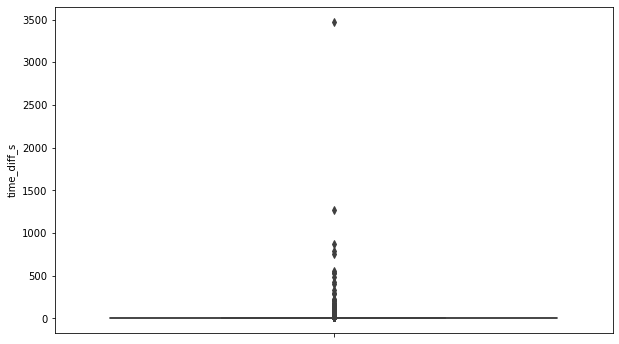

In [20]:
plt.figure(figsize = (10,6))
sns.boxplot(y=a_df['time_diff_s'])

## High Dataset Exploration

In [21]:
h_df = pd.read_csv('../data/high/h_df.csv')

In [22]:
h_df.columns

Index(['timestamp', 'latitude', 'longitude', 'elevation', 'dt', 'heart_rate',
       'bearing', 'time_diff_s', 'total_time_s', 'ele_diff_m',
       'total_ele_change_m', 'lat_lon', 'dist_diff_km', 'total_dist_km',
       'temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'clouds',
       'wind_speed', 'wind_deg'],
      dtype='object')

In [23]:
h_df['time_diff_s'].mean()

4.248005181347151

In [24]:
# check percentage of trackpoints above mean
h_df['time_diff_s'][h_df['time_diff_s'] > 4.248].count()/h_df['time_diff_s'].count()

0.2665025906735751

In [25]:
# h_df['time_diff_s'].value_counts(ascending = False).head(50)

<AxesSubplot:ylabel='time_diff_s'>

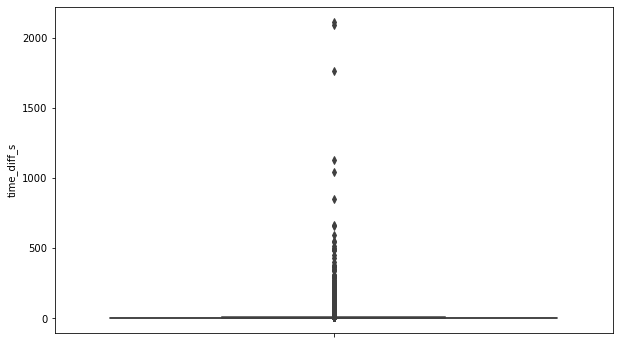

In [26]:
plt.figure(figsize = (10,6))
sns.boxplot(y=h_df['time_diff_s'])

# Create Average Test Dataset and High Test Dataset
---

In [27]:
test_df.columns

Index(['latitude', 'longitude', 'elevation', 'bearing', 'ele_diff_m',
       'total_ele_change_m', 'lat_lon', 'dist_diff_km', 'total_dist_km'],
      dtype='object')

In [28]:
# create copy of test_df to assign average cycling performance time to
a_test_df = test_df.copy()

# assign mean of a_df['time_diff_s'] as a_test_df
a_test_df['time_diff_s'] = a_df['time_diff_s'].mean()
a_test_df['time_diff_s'][0] = 0

# cumulative sum of time_diff_s for total_time_s
a_test_df['total_time_s'] = a_test_df['time_diff_s'].cumsum(skipna = True)

a_test_df.head()

,latitude,longitude,elevation,bearing,ele_diff_m,total_ele_change_m,lat_lon,dist_diff_km,total_dist_km,time_diff_s,total_time_s
0,38.11272,-122.65319,63.04,0.000000,0.00,0.00,"(38.11272, -122.65319000000001)",0.0000,0.0000,0.000000,0.000000
1,38.11343,-122.65308,63.40,6.978612,0.36,0.36,"(38.11343, -122.65308000000002)",0.0795,0.0795,4.615186,4.615186
2,38.11370,-122.65309,63.68,-1.676102,0.28,0.64,"(38.1137, -122.65309)",0.0300,0.1095,4.615186,9.230372
3,38.11425,-122.65358,64.76,-35.140713,1.08,1.72,"(38.114250000000006, -122.65358)",0.0747,0.1842,4.615186,13.845558
4,38.11461,-122.65354,65.55,5.016818,0.79,2.51,"(38.114610000000006, -122.65354)",0.0402,0.2244,4.615186,18.460743


In [29]:
# create copy of test_df to assign average cycling performance time to
h_test_df = test_df.copy()

# assign mean of h_df['time_diff_s'] as h_test_df
h_test_df['time_diff_s'] = h_df['time_diff_s'].mean()
h_test_df['time_diff_s'][0] = 0

# cumulative sum of time_diff_s for total_time_s
h_test_df['total_time_s'] = h_test_df['time_diff_s'].cumsum(skipna = True)
h_test_df.head()

,latitude,longitude,elevation,bearing,ele_diff_m,total_ele_change_m,lat_lon,dist_diff_km,total_dist_km,time_diff_s,total_time_s
0,38.11272,-122.65319,63.04,0.000000,0.00,0.00,"(38.11272, -122.65319000000001)",0.0000,0.0000,0.000000,0.000000
1,38.11343,-122.65308,63.40,6.978612,0.36,0.36,"(38.11343, -122.65308000000002)",0.0795,0.0795,4.248005,4.248005
2,38.11370,-122.65309,63.68,-1.676102,0.28,0.64,"(38.1137, -122.65309)",0.0300,0.1095,4.248005,8.496010
3,38.11425,-122.65358,64.76,-35.140713,1.08,1.72,"(38.114250000000006, -122.65358)",0.0747,0.1842,4.248005,12.744016
4,38.11461,-122.65354,65.55,5.016818,0.79,2.51,"(38.114610000000006, -122.65354)",0.0402,0.2244,4.248005,16.992021


# Get Weather Variables for within 48-hour forecast
---

In [30]:
def get_weather(unix_datetime, lat, lon, API_key = API_key):
    '''
    Using the OpenWeather OneCall 3.0 API to pull weather data by Unix timestamp
    Requires API key for at minimum Startup OpenWeather subscription
    Input: UNIX datetime for time requesting, latitude and longitude of location
    Output: Pandas dataframe for that datetime and location's weather
    '''
    
    url_hist_point = f"https://api.openweathermap.org/data/3.0/onecall/timemachine?lat={lat}&lon={lon}&dt={unix_datetime}&appid={API_key}"
    hist_point_req = requests.get(url_hist_point)

    wd_hist = hist_point_req.json()

    wd_hist_df = json_normalize(wd_hist['data'])
    wd_hist_df = wd_hist_df[['dt', 'temp', 'feels_like', 'pressure', 'humidity',
           'dew_point', 'clouds', 'wind_speed', 'wind_deg']]
    
    return wd_hist_df

In [31]:
def combine_df_forecast(df, unix_start_time):
    
    df['dt'] = unix_start_time + df['total_time_s'].astype(int)
    
    weather_df = pd.DataFrame()
    for i in range(len(df)): # iterate through each trackpoint
        # 600 calls per minute
        unix = df['dt'][i]
        lat = df['latitude'][i]
        lon = df['longitude'][i]
        weather = get_weather(unix, lat, lon) # get historical weather for trackpoint
        weather_df = weather_df.append(weather) # append to weather dataframe

    df = df.merge(weather_df, how = 'inner', on = 'dt') # merge activity dataframe with weather dataframe on unix time stamp
    
    # Convert dt UNIX to datetime UTC
    df['datetime'] = df['dt'].apply(lambda x: datetime.fromtimestamp(x))
    
    return df

## Test Sets combined w/ Weather

In [32]:
# a_test_df = combine_df_forecast(a_test_df, 1660748400) # forecast for 08/17/2022 from 08/12/2022
# h_test_df = combine_df_forecast(h_test_df, 1660748400) # forecast for 08/17/2022 from 08/12/2022

# Save Test CSVs

In [33]:
# a_test_df.to_csv('../data/a_test_df.csv', index = False)
# h_test_df.to_csv('../data/h_test_df.csv', index = False)